## Multi-Layer Perceptron regressor

### Import libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import numpy as np
import pandas as pd
import seaborn as sns
import random
from matplotlib import pyplot as plt
import time

C:\Users\andre\AppData\Local\Temp\ipykernel_20552\3531348005.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Understanding the data

In [2]:
# Adjustment of visibility of Datafreames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

df = pd.read_csv("./data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [3]:
print("##################### Shape #####################")
print(df.shape)
print("##################### Types #####################")
print(df.dtypes)
print("##################### NA #####################")
print(df.isnull().sum())
# print("##################### Quantiles #####################")
# print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### NA #####################
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


#### Missing values

Check if there are missiong values in the dataset

In [5]:
df.isnull().values.any()

False

In [6]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

However, pandas does not identify missing values as Na or NaN. Values like 0 may indicate a missing value for a numeric feature.

`Value Assignment Methods:` We can fill the NaN values with the column's mean, median, mode, etc. If the distribution is homogeneous, filling with median or mean is logical. Also, in some scenarios, filling with a specific number like 0 would make sense.

Assing 0 values to the relevant values as NaN and then apply the operations to the missing values. Those features with a 0 value may represent a missing value as a person's glucose or insulin can not be 0.

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # report
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')         # the number of categorical variables
    print(f'num_cols: {len(num_cols)}')         # the number of numerical variables
    print(f'cat_but_car: {len(cat_but_car)}')   # the number of cardinal variables
    print(f'num_but_cat: {len(num_but_cat)}')   # the number of categorical variables that looks numerical
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [8]:
num_cols_miss = [i for i in num_cols if i != "Pregnancies"]
for i in num_cols_miss:
    df[i] = df.apply(lambda x: np.nan if x[i] == 0 else x[i], axis=1)

In [9]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50.000,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31.000,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32.000,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1


### After missing values pre-processing

In [10]:
df_fill = df.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
df_fill.head(5) # after filling

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1


### Dividing the dataset into training and test data

In [11]:
data_X = df_fill.loc[:, df_fill.columns != "Outcome"]
data_Y = df_fill[["Outcome"]]

print("data_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()

data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 48.1 KB

data_Y info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Outcome  768 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


In [12]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,
                                                    test_size=0.2,
                                                    stratify=data_Y,
                                                    random_state=0)

train_X.reset_index(drop=True, inplace=True)
test_X.reset_index(drop=True, inplace=True)
train_Y.reset_index(drop=True, inplace=True)
test_Y.reset_index(drop=True, inplace=True)

data_Y["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

### Standardization

To increase the learning performance, input features are standardized. Mean and standard deviation of the feeature are computed. Then, mean is subtracted from each sample of the feature and result is devided by standard deviation. The aim is to transform the feature to have mean of 0 and standard deviation of 1. StandardScaler of scikit-learn is used. A StandardScaler is fit to the feature in train_X, then this scaler transforms the same feature in train_X and test_X.

In [13]:
feature_names = train_X.columns

scaler = StandardScaler()

## Fit to train_X
scaler.fit(train_X)

## transform train_X
train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

## transform test_X
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)


In [14]:
train_X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.880,2.482,1.408,-0.052,-0.167,1.098,-0.079,0.627
1,-0.578,-1.356,-0.057,-1.632,-0.747,-0.336,0.202,-0.721
2,-0.578,0.179,-1.197,-0.617,1.608,-0.690,3.284,-0.721
3,-1.162,-0.555,-0.383,-0.842,-0.167,-1.828,-0.708,-0.973
4,-0.870,2.382,-1.849,-1.519,2.792,-0.956,0.518,-0.805


In [15]:
test_Y.head()

,Outcome
0,0
1,0
2,0
3,1
4,0


### Simulated annealing

The algorithm starts with a random solution, iteratively mutate, and decides whether to keep the new solution based on the temperature and change in fitness. The best solution is tracked throughout the iterations.

new_fitness: 0.7857142857142857
change_in_fitness: 0.0
Current solution: ['sgd', 'identity', 52, 0.050100000000000006, 0.07100000000000001]
fitness_over_time: [0.7857142857142857, 0.7857142857142857]
Current fitness: 0.7857142857142857
temps: [100, 95.0]
iteration: 0
------------------------------------------------------
new_fitness: 0.7727272727272727
change_in_fitness: -0.012987012987012991
Current solution: ['sgd', 'identity', 52, 0.050100000000000006, 0.07100000000000001]
fitness_over_time: [0.7857142857142857, 0.7857142857142857, 0.7727272727272727]
Current fitness: 0.7727272727272727
temps: [100, 95.0, 90.25]
iteration: 1
------------------------------------------------------
new_fitness: 0.7597402597402597
change_in_fitness: -0.012987012987012991
Current solution: ['sgd', 'identity', 52, 0.050100000000000006, 0.07133809213347873]
fitness_over_time: [0.7857142857142857, 0.7857142857142857, 0.7727272727272727, 0.7597402597402597]
Current fitness: 0.7597402597402597
temps: [100, 95

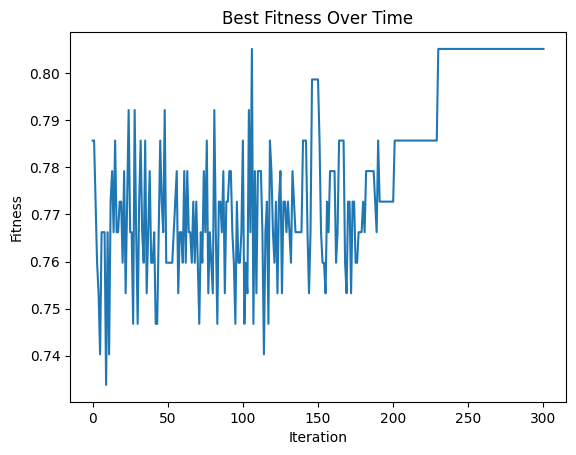

In [16]:
class SimulatedAnnealing:

    def __init__(self, initial_temp, final_temp, cooling_rate, max_iterations, kernel_mutation_prob, 
                 solver_set, activation_set, hidden_layer_sizes_set, alpha_set, learning_rate_init_set):
        """
            Initialize simulated annealing variables.
        """

        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.cooling_rate = cooling_rate
        self.max_iterations = max_iterations
        self.kernel_mutation_prob = kernel_mutation_prob

        self.fitness_over_time = []
        self.temps = []
        self.genome_over_time = []
        self.best_fitness_overtime = {}

        ## Evolved Hyperparameters
        self.solver = solver_set
        self.activation = activation_set
        self.hidden_layer_sizes = hidden_layer_sizes_set
        self.alpha = alpha_set
        self.learning_rate_init = learning_rate_init_set

    def accept_solution(self, change_in_fitness, temperature):
        """
            Accept the change in fitnees or not.
            :param change_in_fitness: The change in fitness --> New fitness - current fitness
            :param temperature: The temperature in that iteration
            :return: True is the change is accepted else False
        """

        ## If the change in fitness is greater than 0, the change is always accepted
        if change_in_fitness > 0:
            return True
        else:
        ## If the change in fitness is less than cero, accept the change with some probability
            p = np.exp(change_in_fitness / temperature)
            if np.random.rand() < p:
                ## Accept the change - return True
                return True
            else:
                ## Reject the change - return False
                return False

    def create_random_hyperparameters_set(self, my_solver, my_activation, my_hidden_layer_sizes, my_alpha, my_learing_rate_init):
        """
            Create random hyperparameters set for MLP model. Uses the previously defined possible parameters to randomly create the first genotype.
            :param solver: List with possible solvers
            :param activation: List with possible activation functions
            :param hidden_layer_sizes: Range of possible hidden layer sizes
            :param alpha: Range of possible alpha values
            :param learning_rate_init: Range of possible learning rate values

            :return: List with random MLP hyperparameter values
        """

        ## Create the output list
        hyper_params = [random.choice(my_solver), random.choice(my_activation), random.choice(my_hidden_layer_sizes), random.choice(my_alpha), random.choice(my_learing_rate_init)]

        return hyper_params

    def get_mlp_fitness(self, my_solver, my_activation, my_hidden_layer_sizes, my_alpha, my_learing_rate_init):
        """
            Cretes MLP model, train and test the model to get the model fitness
            :param solver: Selected MLP solver
            :param activation: Selected activation function
            :param hidden_layer_sizes: Selected hidden layer sizes value
            :param alpha: Selected alpha value
            :param learning_rate_init: Selected learning rate

            :return: MLP F1 Score
        """

        my_mlp = MLPClassifier(solver=my_solver, activation=my_activation, hidden_layer_sizes=my_hidden_layer_sizes, alpha=my_alpha, learning_rate_init=my_learing_rate_init, max_iter=10000)
        my_mlp.fit(train_X, train_Y.values.ravel())
        my_prediction = my_mlp.predict(test_X)
        my_f1_score = f1_score(test_Y, my_prediction, average='micro')

        return my_f1_score

    def random_number_close_range(self, current_value, x, int_value = False):
        """
            Take the current value, add and subtract a constant value x to generate a randon
            value in the range(current_value - x, current_value + x)
            :param current_value: Current value that is the set to be the main value in the range
            :param x: Value to add and subtract to current_value

            :return: Random number in range(current_value - x, current_value + x)
        """

        lower_bound = current_value - x
        upper_bound = current_value + x

        if lower_bound < 0:
            lower_bound = 0

        if int_value:
            ## Generate random integer number between lower and upper bounds
            random_rational_number = random.randint(lower_bound, upper_bound)

        else:
            ## Generate random rational number between lower and upper bounds
            random_rational_number = random.uniform(lower_bound, upper_bound)

        return random_rational_number

    def optimization(self):
        """
            Simulated annealing process.
        """

        ## Create a current random solution
        current_solution = self.create_random_hyperparameters_set(self.solver, self.activation, self.hidden_layer_sizes, self.alpha, self.learning_rate_init)

        ## Current fitness
        current_fitness = self.get_mlp_fitness(my_solver=current_solution[0], my_activation=current_solution[1], my_hidden_layer_sizes=current_solution[2], my_alpha=current_solution[3], my_learing_rate_init=current_solution[4])

        n_genes = len(current_solution)
        self.mutation_rate = 1/n_genes

        ## Set the initial temperature
        temperature = self.initial_temp

        ## We create a fitness_over_time that store all the fitness calculated, to keep track in the changes
        ## A copy is used, as if is not use the case where the change is not accepted, is going to change the 
        ## current_fitness, but using .copy() does not change the original value of current_fitness
        self.fitness_over_time.append(current_fitness.copy())
        ## Store the temperature through iterations
        self.temps.append(temperature)
        ## Store the genotype through iterations
        self.genome_over_time.append(current_solution.copy())

        ###########################################################

        ## Record start time
        start = time.time()

        ## Do it until reach the maximum iterations
        for iteration in range(self.max_iterations):

            # Generate a neighboring solution with mutation (gene flipping)
            new_solution = current_solution.copy()

            ## Calculate the probability of mutation for each gene and modify it if the random
            ## number generated is lower than the mutation_rate.
            ## This one could flip more than one gene, althought is more likely to not change 
            ## any gen due to the low probability
            for gene_no in range(len(new_solution)):
                
                if np.random.rand() < self.mutation_rate:

                    if gene_no == 0 and np.random.rand() < self.kernel_mutation_prob:
                        new_solution[gene_no] = random.choice(self.solver)
                    elif gene_no == 1 and np.random.rand() < self.kernel_mutation_prob:
                        new_solution[gene_no] = random.choice(self.activation)
                    elif gene_no == 2:
                        # new_solution[gene_no] = random.choice(self.hidden_layer_sizes)
                        new_solution[gene_no] = self.random_number_close_range(new_solution[gene_no], 2, int_value=True)
                    elif gene_no == 3:
                        # new_solution[gene_no] = random.choice(self.alpha)
                        new_solution[gene_no] = self.random_number_close_range(new_solution[gene_no], 0.01)
                    elif gene_no == 4:
                        # new_solution[gene_no] = random.choice(self.learning_rate_init)
                        new_solution[gene_no] = self.random_number_close_range(new_solution[gene_no], 0.001)

            ## Calculate the fitness for the new solution
            new_fitness = self.get_mlp_fitness(my_solver=new_solution[0], my_activation=new_solution[1], my_hidden_layer_sizes=new_solution[2], my_alpha=new_solution[3], my_learing_rate_init=new_solution[4])
            print(f"new_fitness: {new_fitness}")

            ## Calculate the change in the fitness, use to know whether to accepted or not later
            change_in_fitness = new_fitness - current_fitness
            print(f"change_in_fitness: {change_in_fitness}")

            ## Check if new solution should be accepted, if not accepted just go to the next iteration
            ## and ignore the new fitness
            if self.accept_solution(change_in_fitness, temperature):
                current_solution = new_solution.copy()
                current_fitness = new_fitness.copy()
            
            print(f"Current solution: {current_solution}")

            ## Add the new fitness to fitness_over_time to plot the changes in fitness later
            self.fitness_over_time.append(current_fitness.copy())
            print(f"fitness_over_time: {self.fitness_over_time}")

            ## Track solutions with high fitness
            print(f"Current fitness: {current_fitness}")
            if current_fitness >= 0.82:
                self.best_fitness_overtime[current_fitness] = current_solution

            ## Cool down
            temperature *= self.cooling_rate
            self.temps.append(temperature)
            print(f"temps: {self.temps}")

            print(f"iteration: {iteration}")

            print("------------------------------------------------------")

        ## Record en time
        end = time.time()

        ## Print execution time
        execution_time = end - start
        print(f"Execution time: {execution_time:.2f}")

        ##Print the final solution
        print(f"Best solution: {current_solution}")
        best_solution_fitness = current_fitness
        print(f"Best solution fitness: {best_solution_fitness}")

        ## Prin best fitness over time dict
        print(self.best_fitness_overtime)

        plt.plot(self.fitness_over_time)
        plt.title("Best Fitness Over Time")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness")
        plt.show()

def main():
    ## Initial Simulated annealing values
    init_initial_temp = 100
    init_final_temp = 0.01
    init_cooling_rate = 0.95
    init_max_iterations = 300
    init_kernel_mutation_prob = 0.03

    ## Initial hyperparameters
    init_solver = ['lbfgs', 'sgd', 'adam']
    init_activation = ['identity', 'logistic', 'tanh', 'relu']
    init_hidden_layer_sizes = np.arange(20, 200, 1)
    init_alpha = np.arange(0.0001, 0.1, 0.001)
    init_learning_rate_init = np.arange(0.001, 0.1, 0.001)

    ## cooling rate 0.99
    sa_optimization = SimulatedAnnealing(initial_temp=init_initial_temp, 
                                        final_temp=init_final_temp, 
                                        cooling_rate=init_cooling_rate, 
                                        max_iterations=init_max_iterations, 
                                        kernel_mutation_prob=init_kernel_mutation_prob,
                                        solver_set=init_solver,
                                        activation_set=init_activation,
                                        hidden_layer_sizes_set=init_hidden_layer_sizes,
                                        alpha_set=init_alpha,
                                        learning_rate_init_set=init_learning_rate_init)

    sa_optimization.optimization()

if __name__ == "__main__":
    main()